# CCFDetector: Using ML against Credit Card Frauds

L'obiettivo di questo progetto, realizzato per l'esame di Fondamenti di Intelligenza Artificiale presso l'Univeristà degli Studi di Salerno, è quello di realizzare un sistema di Machine Learning per l'individuazione di transazioni fraudolente relative ai pagamenti elettronici, cioè tutte quelle transazioni effettuate da carte di credito non in possesso dell'autore della transazione.
## Setup del progetto e Data Understanding
---
### Inizio ad importare le librerie necessarie

In [19]:
# import the necessary packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import gridspec

### Carico il dataset

In [20]:
data = pd.read_csv('creditcard.csv')
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


### Descrizione del dataset
Il dataset utilizzato, contiene le transazioni effettuate da carte di credito in due giorni del settembre del 2013. Molte delle features (da *V1* a *V28*) sono riservate, ovviamente, per motivi di privacy. Le uniche features che non sono state nascoste sono *Time*, che rappresenta il tempo, in secondi, tra la transazione corrispondente e la prima transazione del dataset, *Amount*, che rappresenta l'ammontare, appunto, della transazione, e, infine, *Class*, che assume valore 1 se la transazione è stata segnalata come fraudolenta, 0 altrimenti. 
Vado, ora, ad analizzare il dataset per verificare se sia *unbalanced*, come mi aspetto, oppure no.

In [21]:
# Checking n. of frauds in the dataset
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]
ratio = len(fraud)/float(len(valid))
print(ratio)
print('Fraud cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid cases: {}'.format(len(data[data['Class'] == 0])))

0.0017304750013189597
Fraud cases: 492
Valid cases: 284315


Come possiamo notare, il dataset è altamente *unbalanced*; infatti, solo lo 0.17% delle transazioni risulta essere etichettato come fraudolento.
A questo punto decido di procedere dapprima con il dataset non bilanciato, per poi bilanciarlo e confrontare i vari modelli.

Inizio analizzando i dettagli relativi alla quantità di denaro utilizzata nelle transazioni fraudolente e nelle transazioni lecite.

In [22]:
print("Dettagli di Amount nelle transazioni fraudolente")
fraud.Amount.describe()

Dettagli di Amount nelle transazioni fraudolente


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [23]:
print("Dettagli di Amount nelle transazioni non fraudolente")
valid.Amount.describe()

Dettagli di Amount nelle transazioni non fraudolente


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Come si può ben notare, le cifre relative alle transazioni fraudolente sono più alte, con una media di 122.2 per le transazioni fraudolente, contro gli 88.2 delle transazioni non fraudolente.
A questo punto, per avere un'idea di come le varie caratteristiche sono correlate tra loro e di quali risultano più rilevanti per la predizione, utilizzo una *matrice di correlazione*.

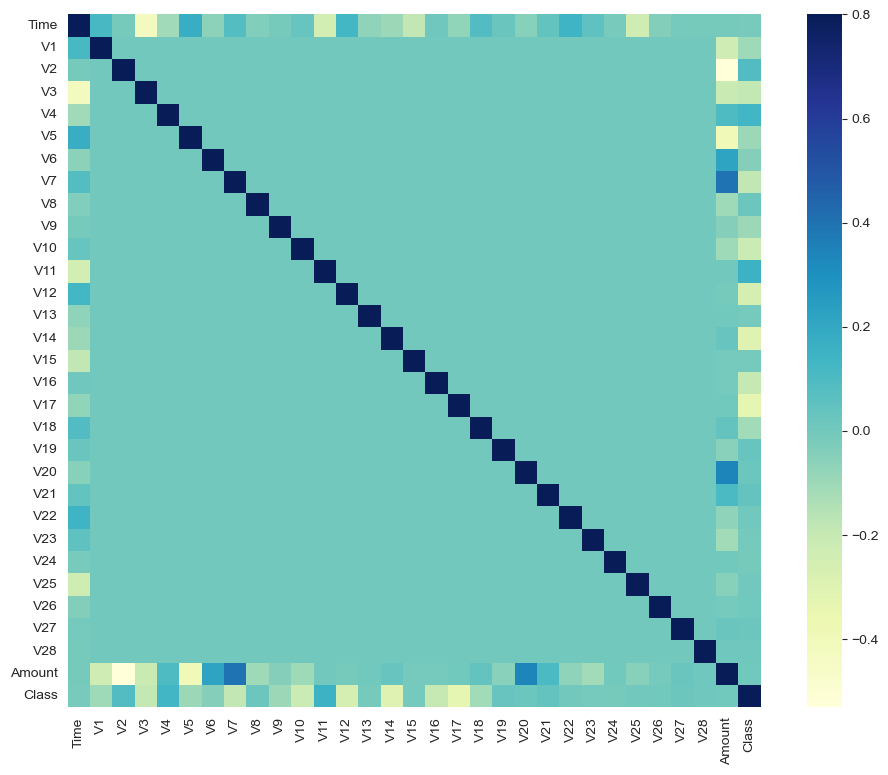

In [24]:
# Plotting a Correlation Matrix
correlation_matrix = data.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(correlation_matrix, vmax = .8, square = True, cmap = 'YlGnBu')
plt.show()

Questa matrice di correlazione mostra come le caratteristiche V7 e V20 hanno una qualche correlazione con l'ammontare di denaro relativo ad una transazione (*Amount*), mentre altre caratteristiche, ad esempio V2, V3 e V5 sono negativamente correlate con questa caratteristica.

## Data Preparation
---
A questo punto, creo un nuovo DataFrame *X*, che contiene le variabili indipendenti (*features*), andando a rimuovere la colonna *Class* dal DataFrame originale e una Serie *Y*, che contiene la variabile dipendente (*target*), nonché la colonna *Class*.  

In [25]:
# Separating dependent variable Y from the indipendent variables
X = data.drop(['Class'], axis=1) # indipendent variables
Y = data['Class'] # target

print(X.shape)
print(Y.shape)

# Converting X and Y into numpy arrays
xData = X.values
yData = Y.values
# print("Printing the arrays...")
# print(xData)
# print(yData)

(284807, 30)
(284807,)


Affinché il modello risulti affidabile, è necessario che il dataset con cui viene addestrato sia diverso dal dataset con cui verrà validato.
Dunque, è necessario dividere il dataset in un *Training Set* e un *Test set*.
Efettuerò una singola divisione del dataset, in particolare utilizzerò il 20% dei dati come Test set.

In [26]:
# Splitting data into training set and test set using Scikit-learn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    xData, yData, test_size=0.2, random_state=42)